In [186]:
import pandas as pd
import numpy as np

import scipy
from scipy.stats import spearmanr, pearsonr
import scipy.cluster.hierarchy as sch

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Define preprocessing function

In [554]:
def import_data():
    # Import data

    col_names = pd.read_csv("communities_names.csv", header = None)
    list_of_column_names = []

    for index, row_data in col_names.iterrows():
        list_of_column_names.append(str(row_data[0]))

    data = pd.read_csv("communities_data.csv", names = list_of_column_names)

    # Remove categorical columns 
    # 1: county and communities have many missing values
    # 2: communityname would be a direct indicator of crime and should be removed
    # 3: state is not that important

    data.drop(labels = ["state", "county", "community", "communityname"],axis = 1, inplace = True)

    # We also remove the fold-column since this is only present for reproducing article findings

    data.drop(labels = ["fold"],axis = 1, inplace = True)

    # Drop columns with missing data
    col_names_missing_vals = pd.read_csv("communities_names_missing.csv", header = None)
    list_of_column_names_missing_vals = []

    for index, row_data in col_names_missing_vals.iterrows():
        list_of_column_names_missing_vals.append(str(row_data[0]))


    data.drop(labels = list_of_column_names_missing_vals,axis = 1, inplace = True)    
    
    # Make data_init
    data_init = data.copy()
    # Make a categorical column for blackness where we set a threshold (just for visualization purposes)
    racepctblack = np.asarray(data.racepctblack)
    threshold = 0.15 # Previously 0.4
    IsBlack = [1 if x>threshold else 0 for x in racepctblack]
    data["IsBlack"] = IsBlack
    
    # Make a categorical column for crime
    crime_rate = np.asarray(data.ViolentCrimesPerPop)
    threshold_crime = 0.7 # Previously 0.04
    HighCrime = [1 if x>threshold_crime else 0 for x in crime_rate]
    data["HighCrime"] = HighCrime
    
    # Make a full dataframe where we have not removed the protected columns or the label
    data_full = data.copy()
    
    # Remove protected features and put into separate dataframe
    # Note: this includes all racepct-columns (black, white, asian, hipspanic), since one can be somewhat derived from the others
    protected_cols = ["IsBlack", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]
    data_protected = pd.concat([data.pop(x) for x in protected_cols], axis=1)
    
    # Remove y column (the label)
    y_cols = ["ViolentCrimesPerPop", "HighCrime"]
    data_y = pd.concat([data.pop(x) for x in y_cols], axis=1)
    
    return data_init, data_full, data, data_protected, data_y



In [555]:
df_init, df_all, df, df_protected, df_y = import_data()

Descriptions:

- **df_init** Has all columns where there is no missing data and which are not continuous. Does not have the user defined threhold-columns (IsBlack and HighCrime)
- **df_all** Has all columns where there is no missing data and which are not continuous, including IsBlack and HighCrime which are defined using threholds
- **df** Has all columns with no missing data and which are not continuous and which are neither protected or the target value
- **df_protected** Has protected columns: "IsBlack", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"
- **df_y** Has y-column (both continuous and threhold): "ViolentCrimesPerPop", "HighCrime"

Ideas for grouping columns if we want to simplify: 

- per capita income (remove the race columns) 
- all the cols with 2 parents

## EDA

In [556]:
df_all.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,IsBlack,HighCrime
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,...,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685,0.094052,0.237979,0.316449,0.058175
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,...,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055,0.240328,0.232985,0.465207,0.234132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.420000,0.520000,0.560000,0.020000,0.100000,0.020000,0.000000,0.070000,0.000000,0.000000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.540000,0.670000,0.700000,0.040000,0.170000,0.070000,0.000000,0.150000,0.000000,0.000000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.660000,0.770000,0.790000,0.070000,0.280000,0.190000,0.000000,0.330000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [557]:
df_all

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,IsBlack,HighCrime
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20,0,0
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67,0,0
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43,1,0
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12,1,0
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09,0,0
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45,1,0
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23,1,0
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19,0,0


#### Imbalance in terms of high/low crime



In [563]:
rows_high_crime = len(df_all[df_all.HighCrime == 1].index)
rows_low_crime = len(df_all[df_all.HighCrime == 0].index)

print(f"Number of rows with high crime is {rows_high_crime}, corresponding to {np.round(100 * rows_high_crime/len(df_all),2)} % of the data")
print(f"Number of rows with high crime is {rows_low_crime}, corresponding to {np.round(100 * rows_low_crime/len(df_all),2)} % of the data")

print(f"Imbalance ratio (IR) is {np.round(rows_low_crime/rows_high_crime,2)}")
      

Number of rows with high crime is 116, corresponding to 5.82 % of the data
Number of rows with high crime is 1878, corresponding to 94.18 % of the data
Imbalance ratio (IR) is 16.19


#### Representations bias: neighbourhoods with a majority of white people are greatly overrepresented

https://www.census.gov/quickfacts/fact/table/US/PST045221

Note: the columns racepctblack, white, asian and hipspanic does not add to one, since individuals can fit into one or more categories. 

According to the census data, at least 13.4 percent of the population is black (up to 2.8 percent more if we take all the people in the 'two or more races' category into consideration as well). So we actually have a slight overrepresentation in the data if we compare with the demographics. However, if we just look at the data as is, then we can see that white people are overrepresented and by consequence, we know much more about predominantly white neighbourhoods. 

In other words: population bias leads to skewed data.

In [558]:
non_black_count = len(df_all[df_all.IsBlack == 0].index)
black_count = len(df_all[df_all.IsBlack == 1].index)

print(f"Number of neighbourhoods categorized as non-black: {non_black_count}, corresponding to {np.round(100 * non_black_count/len(df_all),2)} % of the data")
print(f"Number of neighbourhoods categorized as black: {black_count}, corresponding to {np.round(100 * black_count/len(df_all),2)} % of the data")


print(f"Imbalance ratio (IR) is {np.round(non_black_count/black_count,2)}")
    

Number of neighbourhoods categorized as non-black: 1363, corresponding to 68.36 % of the data
Number of neighbourhoods categorized as black: 631, corresponding to 31.64 % of the data
Imbalance ratio (IR) is 2.16


In [559]:
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

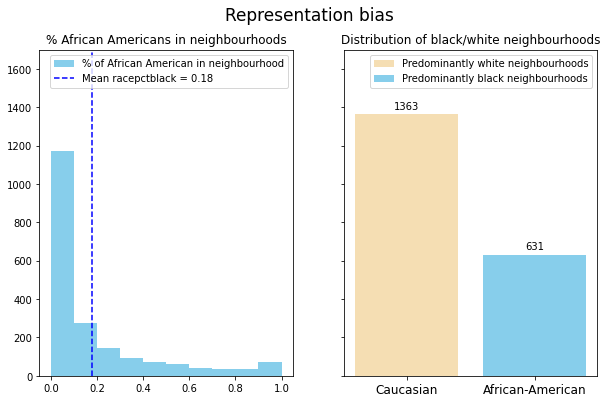

In [576]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6), sharey = True)
fig.suptitle('Representation bias', fontsize = 17)

ax1.hist(df_all.racepctblack, color = 'skyblue', label = "% of African American in neighbourhood")
ax1.axvline(df_all.racepctblack.values.mean(), color = "blue", linestyle = "--", label = f"Mean racepctblack = {np.round(df_all.racepctblack.values.mean(),2)}")
#ax2.set_ylim(top = 1700)

ax1.set_title("% African Americans in neighbourhoods", fontsize = 12)
ax1.legend()

rect1 = ax2.bar(0, non_black_count, label='Predominantly white neighbourhoods', color = 'wheat')
rect2 = ax2.bar(1, black_count, label='Predominantly black neighbourhoods', color = 'skyblue')
ax2.set_xticks([0,1])
ax2.set_xticklabels(["Caucasian","African-American"], rotation = 0, ha = "center", fontsize = 12)
ax2.set_title("Distribution of black/white neighbourhoods", fontsize = 12)
ax2.set_ylim(top = 1700)
autolabel(rect1, ax2)
autolabel(rect2, ax2)

ax2.legend()

plt.savefig("Plots/Representation_bias.png")

plt.show()


### Crime vs. blackness

In [568]:
black_crime = df_all.racepctblack[df_all.HighCrime == 1]
black_no_crime = df_all.racepctblack[df_all.HighCrime == 0]

white_crime = df_all.racePctWhite[df_all.HighCrime == 1]
white_no_crime = df_all.racePctWhite[df_all.HighCrime == 0]



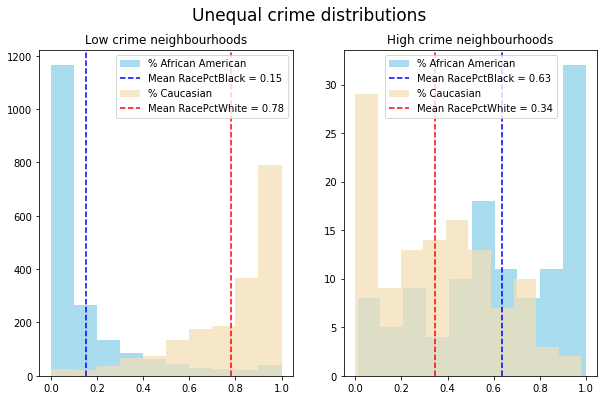

In [573]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6), sharey = False)
fig.suptitle('Unequal crime distributions', fontsize = 17)

ax1.hist(black_no_crime, color = 'skyblue', label = "% African American", alpha = 0.7)
ax1.axvline(black_no_crime.values.mean(), color = "blue", linestyle = "--", label = f"Mean RacePctBlack = {np.round(black_no_crime.values.mean(),2)}")

ax1.hist(white_no_crime, color = 'wheat', label = "% Caucasian", alpha = 0.7)
ax1.axvline(white_no_crime.values.mean(), color = "red", linestyle = "--", label = f"Mean RacePctWhite = {np.round(white_no_crime.values.mean(),2)}")


ax1.set_title("Low crime neighbourhoods", fontsize = 12)
ax1.legend()

ax2.hist(black_crime, color = 'skyblue', label = "% African American", alpha = 0.7)
ax2.axvline(black_crime.values.mean(), color = "blue", linestyle = "--", label = f"Mean RacePctBlack = {np.round(black_crime.values.mean(),2)}")

ax2.hist(white_crime, color = 'wheat', label = "% Caucasian", alpha = 0.7)
ax2.axvline(white_crime.values.mean(), color = "red", linestyle = "--", label = f"Mean RacePctWhite = {np.round(white_crime.values.mean(),2)}")


ax2.set_title("High crime neighbourhoods", fontsize = 12)
ax2.legend()

ax2.legend()

plt.savefig("Plots/Crime_unequal_distributions.png")

plt.show()



### Histograms split on white/black (threhold for IsBlack = 40%)

In [316]:
df_all["NumUnderPov"][df_all.IsBlack == 0].mean()

0.0395082938388625

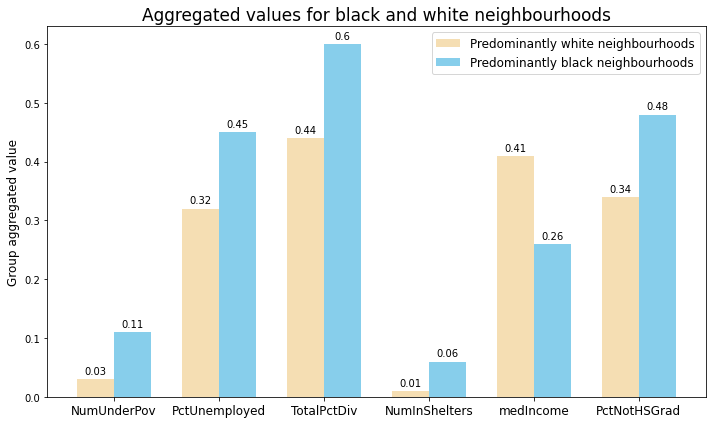

In [581]:
cols_for_hist = ["NumUnderPov", "PctUnemployed", "TotalPctDiv", "NumInShelters", "medIncome", "PctNotHSGrad"]
white_means = []
black_means = []

for i in cols_for_hist:
    white_means.append(np.round(df_all[i][df_all.IsBlack == 0].mean(),2))
    black_means.append(np.round(df_all[i][df_all.IsBlack == 1].mean(),2))


x = np.arange(len(cols_for_hist))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6))
rects1 = ax.bar(x - width/2, white_means, width, label='Predominantly white neighbourhoods', color = 'wheat')
rects2 = ax.bar(x + width/2, black_means, width, label='Predominantly black neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Group aggregated value', fontsize = 12)
ax.set_title('Aggregated values for black and white neighbourhoods', fontsize = 17)
ax.set_xticks(x)
ax.set_xticklabels(cols_for_hist, fontsize = 12)
ax.legend(fontsize = 12)

autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()

plt.savefig("Plots/black_white_aggregate.png")


plt.show()

### Correlations

Here we work with df_all where we have removed the IsBlack and HighCrime cols (the ones we defined with the threshold)

In [265]:
# start by calculating correlation in the dataset
corr_dat = np.ones((df_init.shape[1],df_init.shape[1]))
p_values = np.zeros((df_init.shape[1],df_init.shape[1]))

# go through all features
features = df_init.keys()
for feature_i in range(len(features)):
    for feature_j in range(feature_i,len(features)):
        if feature_i != feature_j:
            
            fi = features[feature_i]
            fj = features[feature_j]
            
            # calculate correlation
            r,p = pearsonr(df_init[fi],df_init[fj])
            
            # save correlation values
            corr_dat[feature_i,feature_j] = r
            # because correlation is symmetric we also fill in the other value
            corr_dat[feature_j,feature_i] = r
            
            # save p-values
            p_values[feature_i,feature_j] = p
            # because correlation is symmetric we also fill in the other value
            p_values[feature_j,feature_i] = p

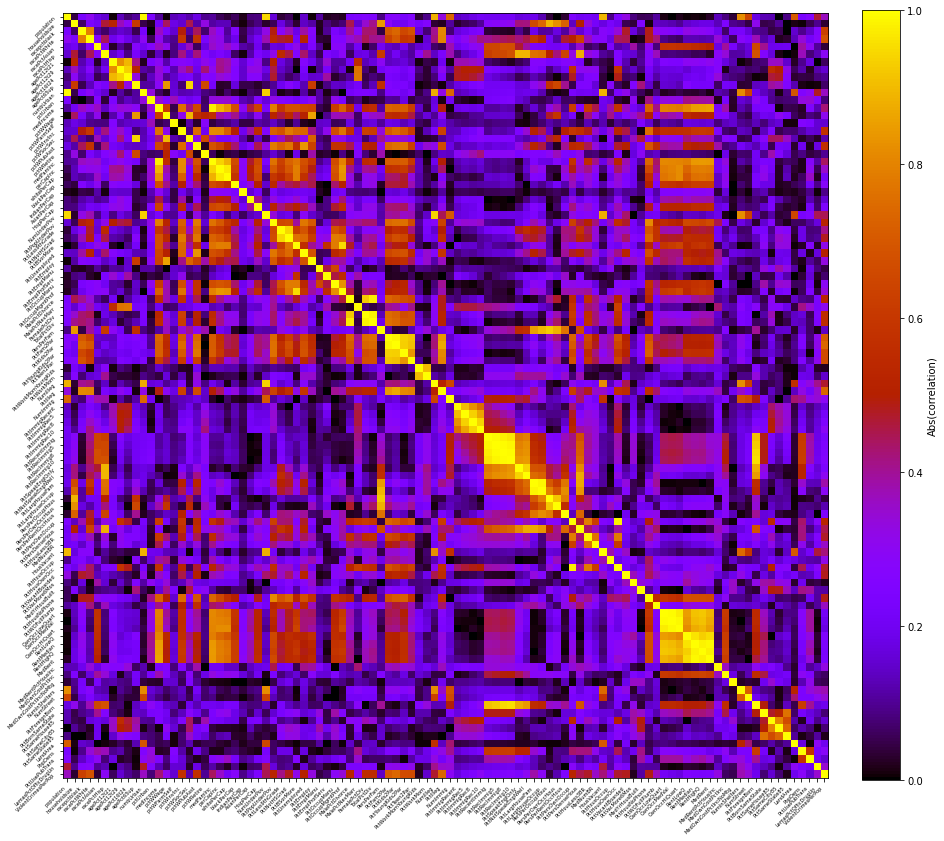

In [266]:
plt.figure(figsize=(15,15))
plt.imshow(abs(corr_dat),cmap=plt.cm.gnuplot,vmin=0,vmax=1)
plt.xticks(range(len(features)),features,fontsize=5,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=5,rotation=45,ha='right')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Abs(correlation)')
#plt.tight_layout()
plt.show()

__There is lots of correlation between the features in our dataset. To be on the safe side plot also the Bonferroni corrected p-values__

In [267]:
corrected_p_value = 0.05 / (len(features)**2/2)
# createa a binary p-value-matrix
corrected_p_matrix = np.ones(p_values.shape)
# threshold it to significatng and non-significant
corrected_p_matrix[p_values >= corrected_p_value] = 0

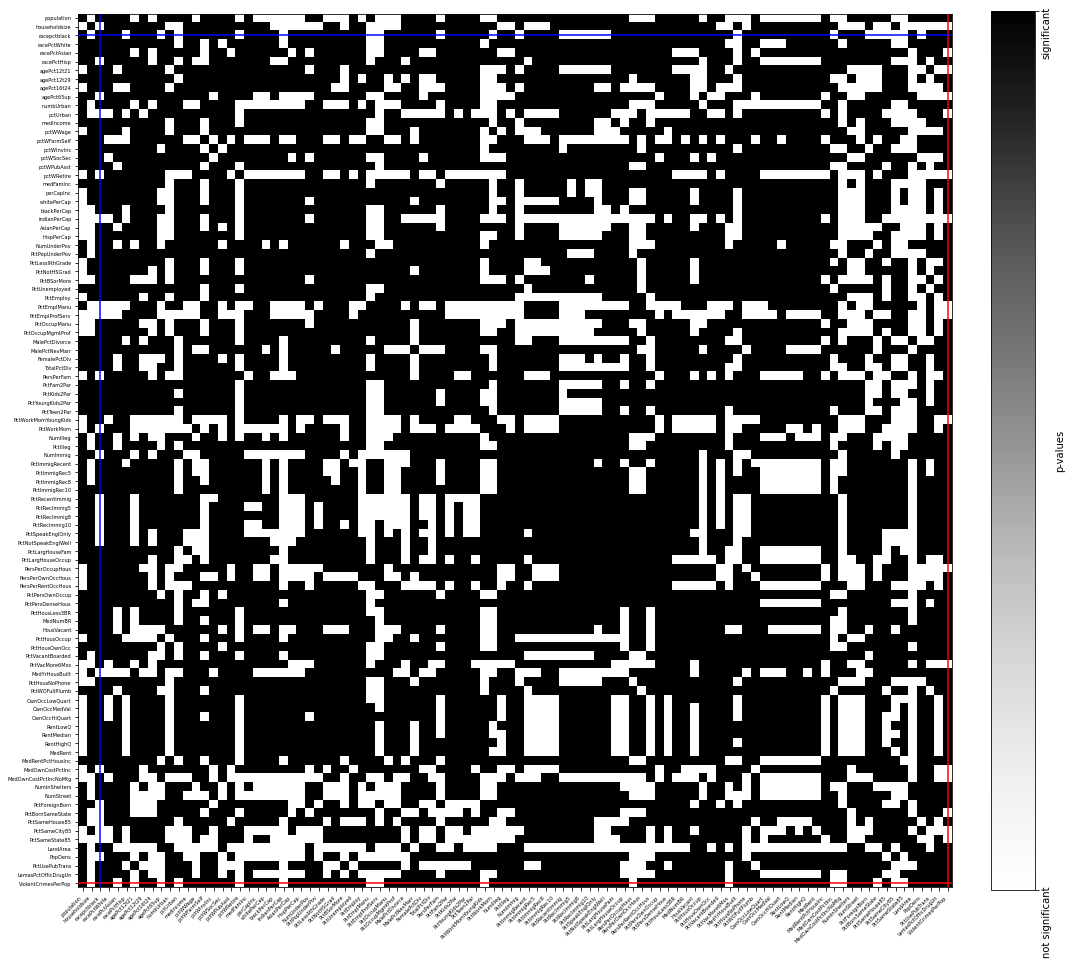

In [268]:
plt.figure(figsize=(15,15))
#plt.imshow(p_values,cmap=plt.cm.greys)
plt.imshow(corrected_p_matrix,cmap=plt.cm.Greys,zorder=2)
plt.axhline(y=features.get_loc("ViolentCrimesPerPop"),color='red',zorder=3)
plt.axvline(x=features.get_loc("ViolentCrimesPerPop"),color='red',zorder=3)

plt.axhline(y=features.get_loc("racepctblack"),color='blue',zorder=3)
plt.axvline(x=features.get_loc("racepctblack"),color='blue',zorder=3)

plt.xticks(range(len(features)),features,fontsize=5,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=5,rotation=0,ha='right')
cbar = plt.colorbar(ticks=[0, 1],fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['not significant','significant'],rotation=90)
cbar.set_label('p-values')
plt.tight_layout()
plt.show()

**Get 10 highest correlations**

Correlations with crime

In [290]:
# Let's get the list of the 10 highest correlation between crime and X
num_corr = 20

corr_crime = corr_dat[features.get_loc("ViolentCrimesPerPop")]

features_sorted_crime = [ y for x,y in sorted(zip(corr_crime, features), key = lambda x: abs(x[0]), reverse = True)]
corr_sorted_crime = [ x for x,y in sorted(zip(corr_crime, features), key = lambda x: abs(x[0]), reverse = True)]

features_10_crime = features_sorted_crime[1:(num_corr+1)]
corr_10_crime = corr_sorted_crime[1:(num_corr+1)]


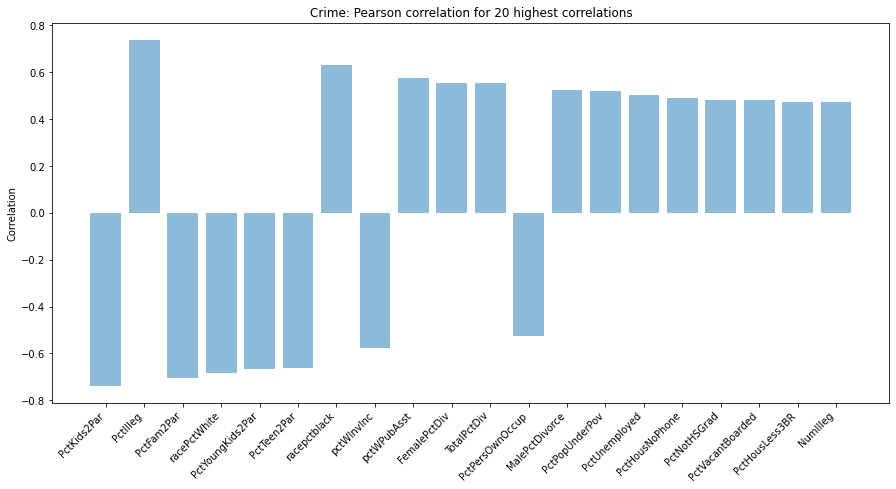

In [295]:
# Plot 10 highest correlations with crime
y_pos = np.arange(len(features_10_crime))

plt.figure(figsize=(15,7))
plt.bar(y_pos, corr_10_crime, align='center', alpha=0.5)
plt.xticks(y_pos, features_10_crime, rotation = 45, ha = 'right')
plt.ylabel('Correlation')
plt.title(f'Crime: Pearson correlation for {num_corr} highest correlations')

plt.show()

Correlations with blackness

In [286]:
# Let's get the list of the 10 highest correlation between crime and X
num_corr = 10

corr_black = corr_dat[features.get_loc("racepctblack")]

features_sorted_black = [ y for x,y in sorted(zip(corr_black, features), key = lambda x: abs(x[0]), reverse = True)]
corr_sorted_black = [ x for x,y in sorted(zip(corr_black, features), key = lambda x: abs(x[0]), reverse = True)]

features_10_black = features_sorted_black[1:(num_corr+1)]
corr_10_black = corr_sorted_black[1:(num_corr+1)]



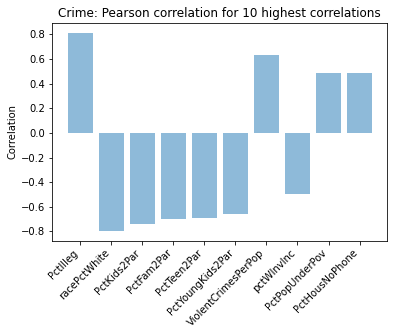

In [287]:
# Plot 10 highest correlations with crime
y_pos = np.arange(len(features_10_black))

plt.bar(y_pos, corr_10_black, align='center', alpha=0.5)
plt.xticks(y_pos, features_10_black, rotation = 45, ha = 'right')
plt.ylabel('Correlation')
plt.title(f'Crime: Pearson correlation for {num_corr} highest correlations')

plt.show()

<AxesSubplot:>

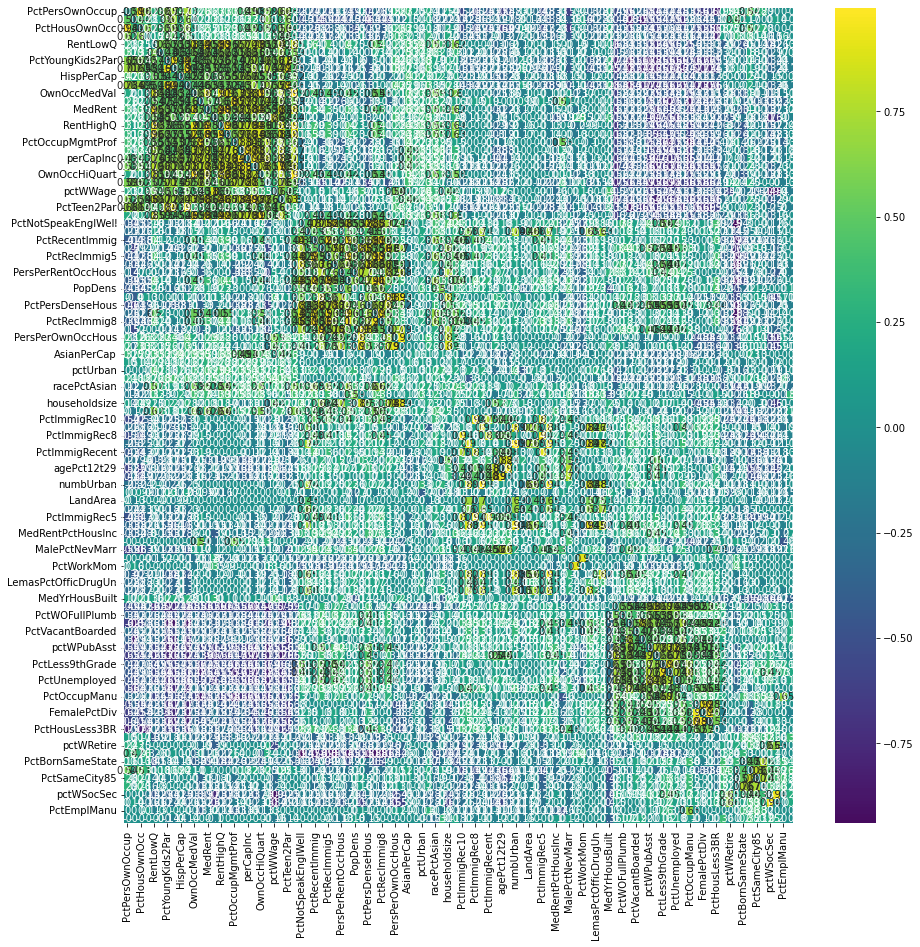

In [289]:
# Helping function to cluster correlations from https://wil.yegelwel.com/cluster-correlation-matrix/
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def get_significant_correlations(df, method="pearson", p_val=0.05):
    corr = df.corr(method)
    # Bonferroni correction
    corrected_p_val = p_val / (len(df.columns)**2/2)
    
    if method == "spearman":
        corr_pvals = df.corr(spearmanr_pval)
    elif method == "pearson":
        corr_pvals = df.corr(pearsonr_pval)
    
    # Set significant values to 1
    significant_matrix = np.ones(corr.shape)
    significant_matrix[corr_pvals >= corrected_p_val] = 0
    # Set un-significant correlations to 0
    corr = corr * significant_matrix
    
    # Return clusrtered corr
    return cluster_corr(corr)
    

fig, ax = plt.subplots(1, figsize=(15,15))
sns.heatmap(get_significant_correlations(df_init), center=0, annot=True, cmap="viridis")